# Plotting of along-slope velocity transformed into ASC coordinate system: seasonality 

This scripts plots a monthly climatology of along-slope velocity data that were transformed into an ASC coordinate system. The transformation is done in `Calc_ASCcoord_transform_ocean.ipynb`.

This script plots the seasonality averaged over different ASC regimes as  defined in `Calc_ASC_regimes.ipynb`.

In [1]:
import cosima_cookbook as cc
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import numpy as np
from dask.distributed import Client

# Optional modules
import cmocean as cm
import xarray.ufuncs as xu

# Ignore warnings
import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

Start a cluster with multiple cores

In [2]:
client = Client() # n_workers=4
client

Client Scheduler: tcp://127.0.0.1:42497 Dashboard: /proxy/33219/status,Cluster Workers: 4 Cores: 8 Memory: 32.00 GiB


Load in pre-calculated data

In [3]:
file_path = '/g/data/x77/wgh581/Post_Process/'
file_name_daily = 'transects_binned_daily_full.nc'
file_name_monthly = 'binned_product_monthly.nc'

ds = xr.open_dataarray(file_path + file_name_monthly)

Barotropic velocity

In [4]:
# Load database
session = cc.database.create_session()
# Define experiment in database
expt = '01deg_jra55v13_ryf9091'

In [5]:
# import edges of st_ocean and add lat/lon dimensions:
st_edges_ocean = cc.querying.getvar(expt, 'st_edges_ocean', session, n=1) # , start_time=start_time, end_time=end_time.
st_edges_array = st_edges_ocean.expand_dims({'lon_shelf':ds.lon_shelf, 'depth_bin':ds.depth_bin}, axis=[1,2])

# adjust edges at bottom for partial thickness:
st_edges_with_partial = st_edges_array.where(st_edges_array<ds.depth_bin, other=ds.depth_bin)
thickness = st_edges_with_partial.diff(dim='st_edges_ocean')

# change coordinate of thickness to st_ocean (needed for multipling with other variables):
st_ocean = cc.querying.getvar(expt, 'st_ocean', session, n=1)
thickness['st_edges_ocean'] = st_ocean.values
thickness = thickness.rename(({'st_edges_ocean':'st_ocean'}))
thickness = thickness

# We only need values down to the deepest depth_bin
st_ocean_slice = slice(0, 2000)
thickness = thickness.sel(st_ocean = st_ocean_slice)

In [6]:
ds_btr = (ds * thickness).sum('st_ocean') / thickness.sum('st_ocean')

Bottom velocity

In [7]:
# Get bottom velocity

# Array that has the depth levels
depth_array_1 = ds[:,0,:,:] * 0 + ds.st_ocean

# Get max depth of data (skipping nans)
max_depth_1   = depth_array_1.max(dim='st_ocean', skipna=True) 

# Select the age using max_depth
# Bottom is where the depth level is larger/equal the max depth
ds_bottom = ds.where(depth_array_1.st_ocean >= max_depth_1)
ds_bottom = ds_bottom.sum(dim='st_ocean')

Surface velocity

In [8]:
ds_surface = ds[:,:,0,:]

Upper 200 m average

In [9]:
ds_200m_avg    = ds.sel(st_ocean=slice(0, 200))
thickness_200m = thickness.sel(st_ocean=slice(0, 200))
ds_200m_avg    = (ds_200m_avg * thickness_200m).sum('st_ocean') / thickness_200m.sum('st_ocean')

Set values out of range to nan

In [10]:
ds_surface = ds_surface.where(ds_surface != 0)
ds_surface = ds_surface.where(ds_surface <= 1)
ds_surface = ds_surface.where(ds_surface >= -1)

In [11]:
ds_bottom = ds_bottom.where(ds_bottom != 0)
ds_bottom = ds_bottom.where(ds_bottom <= 1)
ds_bottom = ds_bottom.where(ds_bottom >= -1)

In [12]:
ds_btr_nan = ds_btr.where(ds_btr != 0)
ds_btr_nan = ds_btr_nan.where(ds_btr <= 1)
ds_btr_nan = ds_btr_nan.where(ds_btr >= -1)

In [13]:
ds_200m_avg = ds_200m_avg.where(ds_200m_avg != 0)
ds_200m_avg = ds_200m_avg.where(ds_200m_avg <= 1)
ds_200m_avg = ds_200m_avg.where(ds_200m_avg >= -1)

Average in cross-slope direction

In [14]:
ds_surface  = ds_surface.mean('depth_bin')
ds_bottom   = ds_bottom.mean('depth_bin')
ds_btr_nan  = ds_btr_nan.mean('depth_bin')
ds_200m_avg = ds_200m_avg.mean('depth_bin')

Atmospheric forcing: surface momentum stress

In [15]:
# x,y components
tau_x = xr.open_dataset(file_path + 'binned_product_monthly_tau_x.nc').tau_x_binned
tau_y = xr.open_dataset(file_path + 'binned_product_monthly_tau_y.nc').tau_y_binned

tau_x = tau_x.mean('depth_bin')
tau_y = tau_y.mean('depth_bin')

tau_x = tau_x.where(tau_x != 0)
tau_x = tau_x.where(tau_x <= 1)
tau_x = tau_x.where(tau_x >= -1)

tau_y = tau_y.where(tau_y != 0)
tau_y = tau_y.where(tau_y <= 1)
tau_y = tau_y.where(tau_y >= -1)

In [16]:
# along-slope and cross-slope components
tau_a = xr.open_dataset(file_path + 'binned_product_monthly_tau_along.nc').tau_x_binned
tau_c = xr.open_dataset(file_path + 'binned_product_monthly_tau_cross.nc').tau_y_binned

tau_a = tau_a.mean('depth_bin')
tau_c = tau_c.mean('depth_bin')

tau_a = tau_a.where(tau_a != 0)
tau_a = tau_a.where(tau_a <= 1)
tau_a = tau_a.where(tau_a >= -1)

tau_c = tau_c.where(tau_c != 0)
tau_c = tau_c.where(tau_c <= 1)
tau_c = tau_c.where(tau_c >= -1)

Sea ice concentration

In [17]:
aice = xr.open_dataset(file_path + 'binned_product_monthly_aice.nc').aice_binned
aice = aice.mean('depth_bin')
aice = aice.where(aice != 0)
aice = aice.where(aice <= 1)
aice = aice.where(aice >= -1)

Get ASC regimes

In [18]:
# Load ASC classification (calculated in Calc_ASC_classification.ipynb)
file_path = '/g/data/x77/wgh581/Post_Process/'
file_name = 'ASC_regimes_01deg_jra55v13_ryf9091_plt_approach_smoothed_btm200m_50.npz'
ASC_regimes = np.load(file_path + file_name)
ASC_regimes = ASC_regimes['ASC_regimes_annual']

In [20]:
# Get lon and lat information of 1-km isobath on which the ASC regimes are calculated.
file_name = 'Antarctic_slope_contour_1km_velocities_plt_approach.npz'
data = np.load(file_path + file_name)

lon_along_contour = data['lon_along_contour']
lat_along_contour = data['lat_along_contour']

In [21]:
# Get indices of where regimes shifts occur
test = np.diff(ASC_regimes)
index_tmp = [0]
ASC_tmp   = []
for ii in range(len(test)):
    if test[ii] != 0:
        lon_tmp = lon_along_contour[ii]
        lat_tmp = lat_along_contour[ii]
        index_tmp.append(np.argmin((ds.lon_shelf.values - lon_tmp)**2) )
        ASC_tmp.append(ASC_regimes[ii-1])
ASC_tmp.append(0)
index_tmp.append(len(ds.lon_shelf.values))

In [22]:
# The ASC coordinate has a different length (compared to the 1-km isobath), so we need to find the lat/lon locations where the ASC regime shifts occur.
ASC_regimes_binned =  np.zeros(len(ds.lon_shelf)) * np.nan
for ii in range(len(ASC_tmp)):
    if ASC_tmp[ii] == 0:
        # Surface-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 0
    elif ASC_tmp[ii] == 1:
        # Bottom-intensified ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 1
    elif ASC_tmp[ii] == 2:
        # Reversed ASC
        ASC_regimes_binned[index_tmp[ii]:index_tmp[ii+1]] = 2
ASC_regimes_binned_2d = np.vstack((ASC_regimes_binned, ASC_regimes_binned))

Mean over regimes

In [23]:
def get_regime_average(in_data):
    out_data = np.zeros((3,12))
    for tt in range(12):
        out_data[0,tt] = np.nanmean(np.where(ASC_regimes_binned==0, in_data[:,tt], np.nan))
        out_data[1,tt] = np.nanmean(np.where(ASC_regimes_binned==1, in_data[:,tt], np.nan))
        out_data[2,tt] = np.nanmean(np.where(ASC_regimes_binned==2, in_data[:,tt], np.nan))
    
    return out_data

btr_seasonal   = get_regime_average(ds_btr_nan)
sfc_seasonal   = get_regime_average(ds_200m_avg)
btm_seasonal   = get_regime_average(ds_bottom)
tau_x_seasonal = get_regime_average(tau_x)
tau_y_seasonal = get_regime_average(tau_y)
tau_a_seasonal = get_regime_average(tau_a)
tau_c_seasonal = get_regime_average(tau_c)
aice_seasonal  = get_regime_average(aice)

Running mean (3 month)

In [24]:
def running_mean_1d(in_data, N):
    out_data = np.empty((np.shape(in_data)[0]))
    cumsum_tmp = np.nancumsum(np.insert(in_data, 0, np.nan))
    var = (cumsum_tmp[N:] - cumsum_tmp[:-N]) / float(N)
    out_data[int(N/2):-int(N/2)] = var
    return out_data

def calc_running_mean_full(in_data, N):
    out_data = np.zeros((3,12))
    for ii in range(3):
        out_data[ii,:] = running_mean_1d(in_data[ii,:], N)
        # First value:
        out_data[ii,0] = (in_data[ii,-1] + np.nansum(in_data[ii,:2])) / N
        # Last value:
        out_data[ii,-1] = (in_data[ii,0] + np.nansum(in_data[ii,-2:])) / N
    
    return out_data

In [25]:
btm_seasonal_rm = calc_running_mean_full(btm_seasonal, 3)
sfc_seasonal_rm = calc_running_mean_full(sfc_seasonal, 3)
tau_a_seasonal_rm = calc_running_mean_full(tau_a_seasonal, 3)

Subdividing bottom-intensified ASC regime into the different regions

In [29]:
ASC_regimes_bottom_Adelie = ASC_regimes_binned.copy()
ASC_regimes_bottom_Adelie[675:] = 0
ASC_regimes_bottom_Ross = ASC_regimes_binned.copy()
ASC_regimes_bottom_Ross[:675] = 0
ASC_regimes_bottom_Ross[1000:] = 0
ASC_regimes_bottom_Weddell = ASC_regimes_binned.copy()
ASC_regimes_bottom_Weddell[:2090] = 0
ASC_regimes_bottom_Weddell[2600:] = 0
ASC_regimes_bottom_Prydz = ASC_regimes_binned.copy()
ASC_regimes_bottom_Prydz[:3000] = 0

In [30]:
btr_seasonal_subdivision = np.zeros((4,12))
sfc_seasonal_subdivision = np.zeros((4,12))
btm_seasonal_subdivision = np.zeros((4,12))
for tt in range(12):
    btr_seasonal_subdivision[0,tt] = np.nanmean(np.where(ASC_regimes_bottom_Adelie==1, ds_btr_nan[:,tt], np.nan))
    btr_seasonal_subdivision[1,tt] = np.nanmean(np.where(ASC_regimes_bottom_Ross==1, ds_btr_nan[:,tt], np.nan))
    btr_seasonal_subdivision[2,tt] = np.nanmean(np.where(ASC_regimes_bottom_Weddell==1, ds_btr_nan[:,tt], np.nan))
    btr_seasonal_subdivision[3,tt] = np.nanmean(np.where(ASC_regimes_bottom_Prydz==1, ds_btr_nan[:,tt], np.nan))
    sfc_seasonal_subdivision[0,tt] = np.nanmean(np.where(ASC_regimes_bottom_Adelie==1, ds_200m_avg[:,tt], np.nan))
    sfc_seasonal_subdivision[1,tt] = np.nanmean(np.where(ASC_regimes_bottom_Ross==1, ds_200m_avg[:,tt], np.nan))
    sfc_seasonal_subdivision[2,tt] = np.nanmean(np.where(ASC_regimes_bottom_Weddell==1, ds_200m_avg[:,tt], np.nan))
    sfc_seasonal_subdivision[3,tt] = np.nanmean(np.where(ASC_regimes_bottom_Prydz==1, ds_200m_avg[:,tt], np.nan))
    btm_seasonal_subdivision[0,tt] = np.nanmean(np.where(ASC_regimes_bottom_Adelie==1, ds_bottom[:,tt], np.nan))
    btm_seasonal_subdivision[1,tt] = np.nanmean(np.where(ASC_regimes_bottom_Ross==1, ds_bottom[:,tt], np.nan))
    btm_seasonal_subdivision[2,tt] = np.nanmean(np.where(ASC_regimes_bottom_Weddell==1, ds_bottom[:,tt], np.nan))
    btm_seasonal_subdivision[3,tt] = np.nanmean(np.where(ASC_regimes_bottom_Prydz==1, ds_bottom[:,tt], np.nan))

In [31]:
# 3 month running mean for Prydz Bay only
sfc_seasonal_subdivision_rm = running_mean_1d(sfc_seasonal_subdivision[-1,:], 3)
btm_seasonal_subdivision_rm = running_mean_1d(btm_seasonal_subdivision[-1,:], 3)
# First value:
sfc_seasonal_subdivision_rm[0] = (sfc_seasonal_subdivision[-1,-1] + np.nansum(sfc_seasonal_subdivision[-1,:2])) / 3
btm_seasonal_subdivision_rm[0] = (btm_seasonal_subdivision[-1,-1] + np.nansum(btm_seasonal_subdivision[-1,:2])) / 3
# Last value:
sfc_seasonal_subdivision_rm[-1] = (sfc_seasonal_subdivision[-1,0] + np.nansum(sfc_seasonal_subdivision[-1,-2:])) / 3
btm_seasonal_subdivision_rm[-1] = (btm_seasonal_subdivision[-1,0] + np.nansum(btm_seasonal_subdivision[-1,-2:])) / 3

### Plotting

In [26]:
ft_size  = 18
fig_path = '/g/data/x77/wgh581/Figures/Figures_Binned/'

In [27]:
# Costum colormap
import matplotlib
colorsList_no4 = [('limegreen'),('blueviolet'),('tomato'),('c')]
CustomCmap_no4 = matplotlib.colors.ListedColormap(colorsList_no4)
colorsList_no3 = [('limegreen'),('blueviolet'),('tomato')]
CustomCmap_no3 = matplotlib.colors.ListedColormap(colorsList_no3)

In [28]:
month = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_short = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

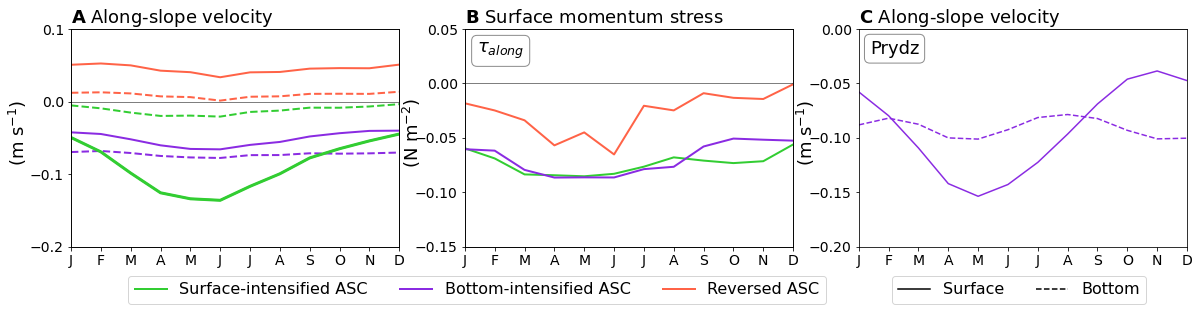

In [34]:
lw = 3
fontsize = 18
styles = ['-', '--']
flow   = ['Surface', 'Bottom', 'Barotropic']
clr_regimes = ['limegreen', 'blueviolet', 'tomato']
lbl_regimes = ['Surface-intensified ASC', 'Bottom-intensified ASC', 'Reversed ASC']
bbox_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.9)

fig = plt.subplots(figsize=(20,4))

## 1 - Overview regimes
ax = plt.subplot(1,3,1)
for ii in range(3):
    # Surface flow
    ax.plot(sfc_seasonal_rm[ii,:], color=clr_regimes[ii], linewidth=lw-1, linestyle=styles[0], label=lbl_regimes[ii])
    # Bottom flow
    ax.plot(btm_seasonal_rm[ii,:], color=clr_regimes[ii], linewidth=lw-1, linestyle=styles[1])
ax.plot(sfc_seasonal_rm[0,:], color=clr_regimes[0], linewidth=lw, linestyle=styles[0])
plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 11)
plt.ylim(-0.2, 0.1)
plt.yticks(np.arange(-0.2, 0.105, 0.1), fontsize=ft_size-4)  
plt.xticks(ticks=np.arange(0, len(month), len(month)/12), labels=month_short, fontsize=ft_size-4)
plt.title(r'$\bf{A}$ Along-slope velocity', fontsize=ft_size, loc='left')
plt.ylabel(r'(m s$^{-1}$)', fontsize=ft_size)
ax.yaxis.set_label_coords(-0.127,0.525)
# Legends
ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss],
             label=flow[ss], c='black')
ax2.get_yaxis().set_visible(False)
ax.legend(fontsize=ft_size-2, bbox_to_anchor=(0.15,-0.3), loc=3, ncol=3) 
ax2.legend(fontsize=ft_size-2, bbox_to_anchor=(3.3,-0.3), loc=4, ncol=2)

## 2 - Surface momentum stress
ax = plt.subplot(1,3,2)
styles = ['-', '--', ':']
flow   = [r'${\tau}$', r'${\tau}_{along}$', r'${\tau}_{cross}$']
for ii in range(3):
    # tau_x 
    ax.plot(tau_a_seasonal_rm[ii,:], color=clr_regimes[ii], linewidth=lw-1, linestyle=styles[0])
plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 11)
plt.ylim(-0.15, 0.05)
plt.yticks(np.arange(-0.15, 0.055, 0.05), fontsize=ft_size-4)
plt.xticks(ticks=np.arange(0, len(month), len(month)/12), labels=month_short, fontsize=ft_size-4)
plt.title(r'$\bf{B}$ Surface momentum stress', fontsize=ft_size, loc='left')
plt.ylabel(r'(N m$^{-2}$)', fontsize=ft_size)
ax.yaxis.set_label_coords(-0.127,0.525)
# Legends
ax2 = ax.twinx()
for ss, sty in enumerate(styles):
    ax2.plot(np.NaN, np.NaN, ls=styles[ss],
             label=flow[ss], c='black')
ax2.get_yaxis().set_visible(False)
plt.text(1.2, 0.044, r"$\tau_{along}$", ha="center", va="center", size=ft_size, bbox=bbox_props)

## 3 - Bottom-intensified areas
ax = plt.subplot(1,3,3)
label_region = ['Adelie/Ross/Weddell', '__noRoss', '__noWeddell', 'Prydz']
color_region = ['0.5', '0.5', '0.5', 'k']
plt.plot(sfc_seasonal_subdivision_rm, linestyle='solid', color=clr_regimes[1], label='Prydz')
plt.plot(btm_seasonal_subdivision_rm, linestyle='dashed', color=clr_regimes[1])
plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 11)
plt.ylim(-0.2, 0)
plt.yticks(np.arange(-0.2, 0.05, 0.05), fontsize=ft_size-4)
plt.xticks(ticks=np.arange(0, len(month), len(month)/12), labels=month_short, fontsize=ft_size-4)
plt.title(r'$\bf{C}$ Along-slope velocity', fontsize=ft_size, loc='left')
ax.set_ylabel(r'(m s$^{-1}$)', fontsize=ft_size)
ax.yaxis.set_label_coords(-0.127,0.525)
plt.text(1.2, -0.018, "Prydz", ha="center", va="center", size=ft_size, bbox=bbox_props)

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_Fig7_ASCcoord_data_seasonality.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

All bottom-intensified ASC regimes

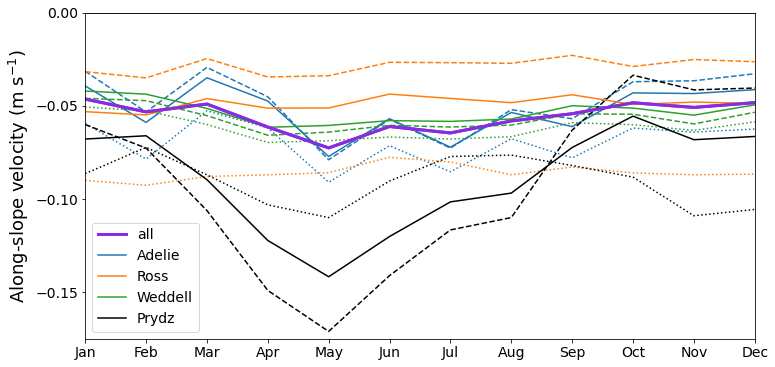

In [66]:
fig = plt.figure(figsize=(12,6))
label_region = ['Adelie', 'Ross', 'Weddell', 'Prydz']
color_region = ['C0', 'C1', 'C2', 'k']
plt.plot(btr_seasonal[1,:], color=clr_regimes[1], label='all', linewidth=lw, linestyle=styles[0])
for ii in range(4):
    plt.plot(btr_seasonal_subdivision[ii,:], linestyle='solid', color=color_region[ii], label=label_region[ii])
    plt.plot(sfc_seasonal_subdivision[ii,:], linestyle='dashed', color=color_region[ii])
    plt.plot(btm_seasonal_subdivision[ii,:], linestyle='dotted', color=color_region[ii])
plt.plot(btr_seasonal[1,:], color=clr_regimes[1], label='__no_label', linewidth=lw, linestyle=styles[0])
plt.legend(fontsize=ft_size-4)

plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 11)
plt.ylim(-0.175, 0)
plt.ylabel('Along-slope velocity (m s$^{-1}$)', fontsize=ft_size)
plt.yticks(np.arange(-0.15, 0.01, 0.05), fontsize=ft_size-4)
plt.xticks(ticks=np.arange(0, len(month), len(month)/12), labels=month, fontsize=ft_size-4);


Sea ice concentration

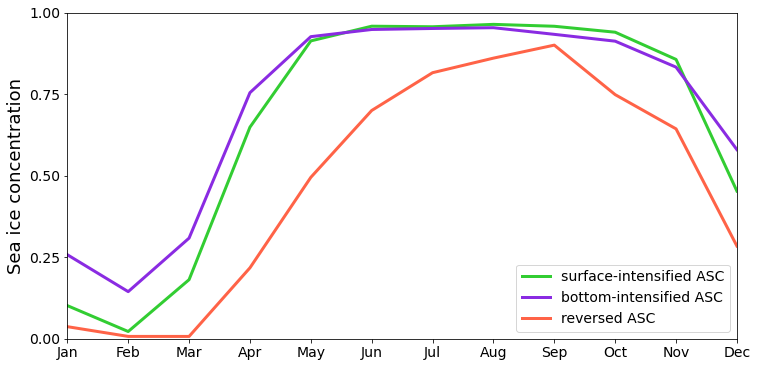

In [84]:
lw = 3
fontsize = 18
styles = ['-', '--', ':']
flow   = [r'${\tau}$', r'${\tau}_x$', r'${\tau}_y$']
clr_regimes = ['limegreen', 'blueviolet', 'tomato']
lbl_regimes = ['surface-intensified ASC', 'bottom-intensified ASC', 'reversed ASC']

fig, ax = plt.subplots(figsize=(12,6))
for ii in range(3):
    ax.plot(aice_seasonal[ii,:], color=clr_regimes[ii], label=lbl_regimes[ii], linewidth=lw, linestyle=styles[0])
    
plt.axhline(0, color='k', linewidth=0.5)
plt.xlim(0, 11)
plt.ylim(0, 1)#0.075)
plt.ylabel('Sea ice concentration', fontsize=ft_size)
plt.yticks(np.arange(0, 1.25, 0.25), fontsize=ft_size-4)
plt.xticks(ticks=np.arange(0, len(month), len(month)/12), labels=month, fontsize=ft_size-4)

# Legends
ax.legend(fontsize=ft_size-4, loc=4)

# Finished
save_fig = 1
if save_fig == 1:
    fig_name = 'Fig_binned_ASC_regimes_seasonality_aice.png'
    plt.savefig(fig_path + fig_name, dpi=150, bbox_inches='tight', facecolor='white')

---

In [55]:
print('Surface velocity')
for ii in range(3):
    a = np.abs(sfc_seasonal_rm[ii,:].min())
    b = np.abs(sfc_seasonal_rm[ii,:].max())
    if ii <= 1:
        print('min is ', np.round(100/a*b), '% of max', np.round(a, 2), np.round(b, 2))
    elif ii == 2:
        print('min is ', np.round(100/b*a), '% of max')

Surface velocity
min is  33.0 % of max 0.14 0.04
min is  61.0 % of max 0.07 0.04
min is  64.0 % of max


In [46]:
print('Momentum stress')
for ii in range(3):
    a = np.abs(tau_a_seasonal_rm[ii,:].min())
    b = np.abs(tau_a_seasonal_rm[ii,:].max())
    print('min is ', np.round(100/a*b), '% of max')

Momentum stress
min is  66.0 % of max
min is  59.0 % of max
min is  1.0 % of max


In [50]:
print('Surface velocity')
for ii in range(3):
    a = np.abs(sfc_seasonal_rm[ii,:].min())
    b = np.abs(sfc_seasonal_rm[ii,:].max())
    if ii <= 1:
        print('increase by', np.round(100/b*a), '%')
    elif ii == 2:
        print('increase by', np.round(100/a*b), '%')

Surface velocity
increase by 304.0 %
increase by 164.0 %
increase by 157.0 %


In [51]:
print('Momentum stress')
for ii in range(3):
    a = np.abs(tau_a_seasonal_rm[ii,:].min())
    b = np.abs(tau_a_seasonal_rm[ii,:].max())
    print('increase by', np.round(100/b*a), '%')

Momentum stress
increase by 152.0 %
increase by 171.0 %
increase by 8665.0 %
